# Trabalho prático - Predição de Spam


## 1) Bibliotecas e funções usadas

### 1.1) Bibliotecas necessárias 

In [80]:
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay


color = sns.color_palette()
plt.style.use("ggplot")

### 1.2) Funções úteis

In [77]:
# Gráfico com a interpretação dos dados
def modelResultsChart(x, y, labels_x, title):
    # Plot scores on each trial for nested and non-nested CV
    plt.figure()
    plt.bar(range(x), y, color="r")

    plt.ylabel("score", fontsize="14")
    plt.xticks(range(x), labels_x, fontsize=4)
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xlabel("Parâmetros otimizados na validação")

    plt.title(
    title,
    x=0.5,
    y=1.1,
    fontsize="15",
    )
    

    plt.show()


## 2) Carregar dados do DB

In [50]:
nomes = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your',	'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl',	'word_freq_george',	'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology',	'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21', 'char_freq_%24', 'char_freq_%23', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'class']

spam = pd.read_csv("./spambase.data", names=nomes)

# Separar as classes dos atributos
X = spam.loc[:, spam.columns.difference(['class'])] # Matriz com as features 
y = spam.loc[:,'class']    # Vetor com as classes 

# Análise dos atributos
print(spam.describe())  # Evidencia valores com escalas diferentes 
print(spam.duplicated().sum)    # Evidencia os valores repetidos do dataset 
spam = spam.drop_duplicates(keep='first')


       word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     4601.000000        4601.000000    4601.000000   4601.000000   
mean         0.104553           0.213015       0.280656      0.065425   
std          0.305358           1.290575       0.504143      1.395151   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.420000      0.000000   
max          4.540000          14.280000       5.100000     42.810000   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    4601.000000     4601.000000       4601.000000         4601.000000   
mean        0.312223        0.095901          0.114208            0.105295   
std         0.672513        0.273824          0.391441            0.401071   
min         0.000000        0.

## 3) Análise do DB


### 3.1) Visualização das classes do DB:
A visualização das classes permite observar que o Database é levemente não balanceado 

In [51]:
dist = spam['class'].value_counts()
colors = ['mediumturquoise', 'darkorange']
trace = go.Pie(values=(np.array(dist)),labels=dist.index)
layout = go.Layout(title='Spam')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

### 3.2) Normalização do DB
Através do método describe observa-se que os atributos não possuem escalas iguais. Logo, é necessários normalizá-los.

In [53]:
# print(spam.describe())
normPadrao = StandardScaler()

# Ajusta os dados e transforma eles
X_norm = normPadrao.fit_transform(X)

X_norm = pd.DataFrame(X_norm)

## 4) Modelos 
Com o obejtivo de desenvolver modelos que classificam corretamento e-mail spam e levando em conta o desbalanceamento das classes a métrica de avaliação utilizada será o F-beta score.

### 4.1) SVM
#### - Hiperparâmetros

- Parêmetro C: Penalidade para cada ponto de dado classificado errado. Um C pequeno representa pouca penalidade para erros na classificação, enquanto que um valor alto desse parâmetro pode resultar em overfitting.
- Parâmetro Gamma: Para kernel não lineares o gamma define o grau de influência do kernel trick. Por exemplo, para a função kernel RBF o gamma representa a distância de influência de um único ponto de dados.

### 4.3) KNN
#### - Hiperparâmetros 
- Número de vizinhos 
- Função de pesos (weights): Forma como os vizinhos influenciam na predição

### 4.2) MLP

#### - Hiperparâmetros 
- Função de ativação 
- Taxa de aprendizado 
- Número de neurônios por camada 


### 5) Treinamento com validação cruzada aninhada com otimização de hiperparâmetros


#### 5.1) Função de treinamento, teste e otimização


In [60]:
def optimizedCrossValidation(tunning, clf, X, y, n_splits_out = 3, n_splits_in = 3):
    # Estrategias de validação cruzada
    cv_in = KFold(n_splits=n_splits_out, shuffle=True, random_state=1)
    cv_ex = KFold(n_splits=n_splits_in, shuffle=True, random_state=1)
    scores = []
    tunning_parameters = []

    num_folder = 1
    # Validação cruzada externa
    for treino_index, teste_index in cv_ex.split(X, y):
        # Validação cruzada interna 
        print('\nValidação cruzada {} da divisão externa {}'.format(num_folder, cv_ex.get_n_splits()))
        num_folder += 1

        # Separa o dataset em treino e teste
        X_treino, X_teste = X.loc[treino_index], X.loc[teste_index]
        y_treino, y_teste = y.loc[treino_index], y.loc[teste_index]

        # Otimização de parametros (treino, validação)
        modelo = GridSearchCV(estimator=clf, param_grid=tunning, cv=cv_in, scoring='f1')
        modelo.fit(X_treino, y_treino)
        tunning_parameters.append(modelo.best_params_)
        print('\nMelhor valor de Hiperparâmetros: {}'.format(modelo.best_params_))

        # Teste nos dados de treino com os parâmetro otimizados 
        y_prev  = modelo.predict(X_teste)
        score = f1_score(y_teste, y_prev)
        scores.append(score)
        print('\nPrecisão nos dados de teste: {}'.format(score))


    modelResultsChart(len(scores), scores, tunning_parameters, "Score na validação cruzada com otimização de parâmetros")
   


#### 5.2) SVM 


Validação cruzada 1 da divisão externa 2

Melhor valor de Hiperparâmetros: {'C': 100, 'gamma': 0.001}

Precisão nos dados de teste: 0.9154616240266963

Validação cruzada 2 da divisão externa 2

Melhor valor de Hiperparâmetros: {'C': 10, 'gamma': 0.01}

Precisão nos dados de teste: 0.9164297896532121


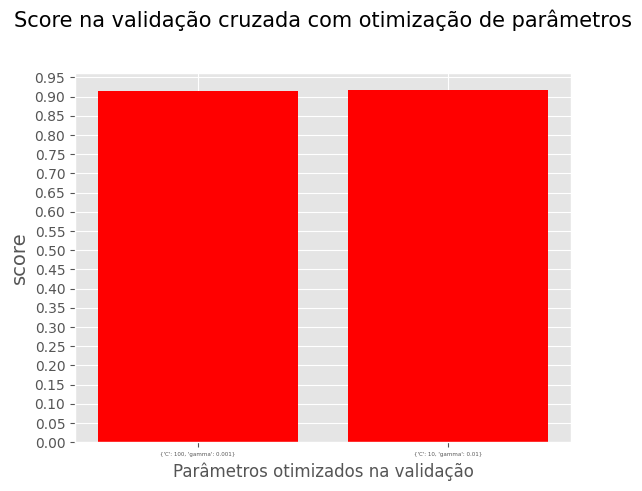

In [81]:

tunnig = {"C":[1, 10, 100], "gamma": [0.1, 0.01, 0.001]}

svm_clf = svm.SVC(kernel='rbf')

optimizedCrossValidation(tunnig, svm_clf, X_norm, y, n_splits_out = 2, n_splits_in = 2)

    

#### 5.3) KNN


Validação cruzada 1 da divisão externa 3

Melhor valor de Hiperparâmetros: {'n_neighbors': 5, 'weights': 'distance'}

Precisão nos dados de teste: 0.891846921797005

Validação cruzada 2 da divisão externa 3

Melhor valor de Hiperparâmetros: {'n_neighbors': 10, 'weights': 'distance'}

Precisão nos dados de teste: 0.8841059602649006

Validação cruzada 3 da divisão externa 3

Melhor valor de Hiperparâmetros: {'n_neighbors': 10, 'weights': 'distance'}

Precisão nos dados de teste: 0.9047619047619049


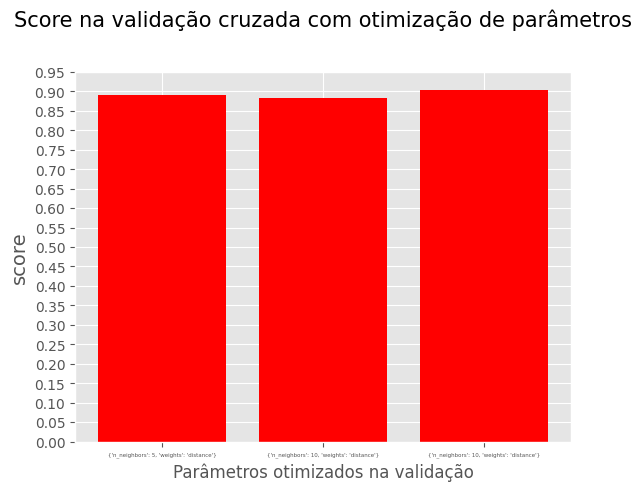

In [78]:
tunnig = {"n_neighbors":[5, 10, 50], "weights": ['uniform', 'distance']}

knn_clf = KNeighborsClassifier()

optimizedCrossValidation(tunnig, knn_clf, X_norm, y)

#### 5.4) MLP


Validação cruzada 1 da divisão externa 3

Melhor valor de Hiperparâmetros: {'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.001}

Precisão nos dados de teste: 0.9341590612777053

Validação cruzada 2 da divisão externa 3

Melhor valor de Hiperparâmetros: {'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.01}

Precisão nos dados de teste: 0.9328552803129074

Validação cruzada 3 da divisão externa 3

Melhor valor de Hiperparâmetros: {'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.01}

Precisão nos dados de teste: 0.9517286366601435


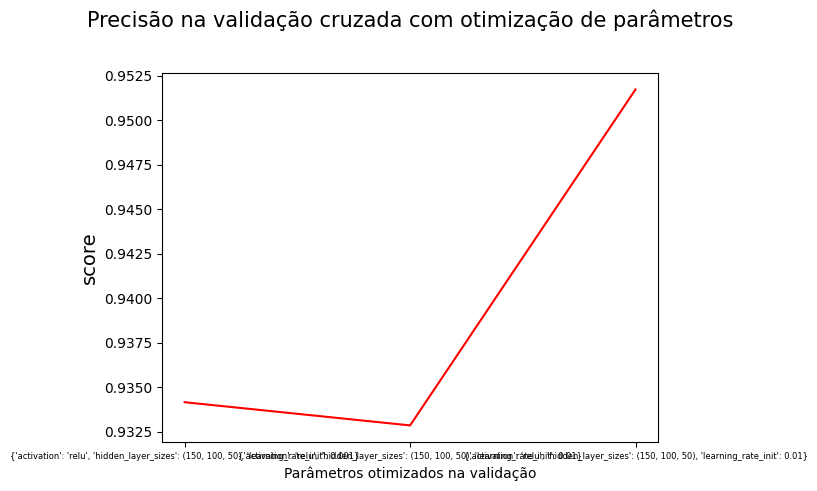

In [ ]:
tunnig = {"hidden_layer_sizes":[(150,100,50), (100,100,100)], 
          "activation":['relu', 'tanh'], 
          "learning_rate_init": [0.001, 0.01]}

mlp_clf = MLPClassifier()

optimizedCrossValidation(tunnig, mlp_clf, X_norm, y)

## Referências 
1) https://towardsdatascience.com/a-beginners-guide-to-data-analysis-in-python-188706df5447
2) https://medium.com/@tonop15/spambase-data-exploration-analysis-9a3d6d83ee78
3) https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167
4) https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
5) https://scikit-learn.org/stable/index.html
6) https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
7) https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b
8) https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning
9) https://www.v7labs.com/blog/train-validation-test-set
10) https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py
